In [3]:
import numpy as np

In [20]:
import networkx as nx
import itertools

In [70]:
def randomly_sample_dag(num_nodes, edge_prob, permute=False):
    adj = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.random.rand() < edge_prob:
                adj[i,j] = 1

    # randomly permute
    if permute:
        perm = np.random.permutation(num_nodes)
        adj = adj[perm,:][:,perm]
        return adj, perm
    else:
        return adj

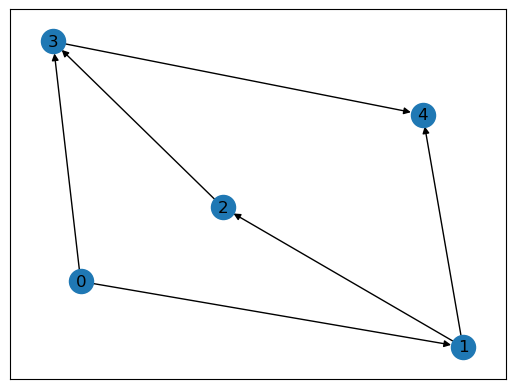

In [71]:
adj = randomly_sample_dag(5, 0.5)
nx.draw_networkx(nx.DiGraph(adj))

In [72]:
import scipy.stats

In [79]:
n = 8
num_nodes = 5
p = 0.5
dirichlet_alpha = 2

def generate_sample(d, n, edge_prob=0.5, dirichlet_alpha=2, permute=True):
    adj = randomly_sample_dag(d, edge_prob)

    xs = []
    for i in range(d):
        ancestors = np.where(adj[:,i] == 1)[0]
        if len(ancestors) == 0:
            xi = np.random.normal(0, 1, size=(n,))
            xs.append(xi)
            continue
        convex = scipy.stats.dirichlet(alpha=[dirichlet_alpha]*len(ancestors)).rvs()[0]
        mean = sum(convex[j] * xs[ancestors[j]] for j in range(len(ancestors)))
        xi = np.random.normal(mean, 1)
        xs.append(xi)

    xs = np.array(xs)

    if permute:
        perm = np.random.permutation(d)
        adj = adj[perm,:][:,perm]
        xs = xs[perm,:]

    return xs, adj

(5, 16)


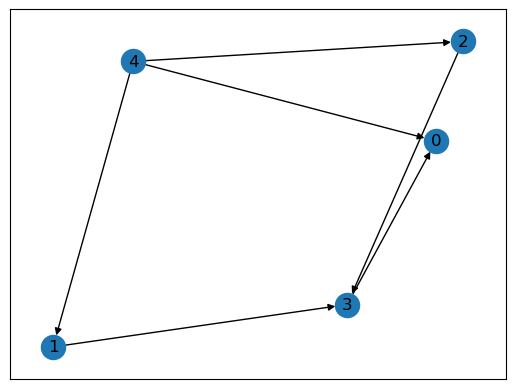

In [80]:
xs, adj = generate_sample(5, 16, edge_prob=p, dirichlet_alpha=dirichlet_alpha)
nx.draw_networkx(nx.DiGraph(adj))
print(xs.shape)

In [81]:
def generate_batch(d, n, batch_size, edge_prob=0.5, dirichlet_alpha=2, permute=True):
    xs = []
    adjs = []
    for _ in range(batch_size):
        x, adj = generate_sample(d, n, edge_prob=edge_prob, dirichlet_alpha=dirichlet_alpha, permute=permute)
        xs.append(x)
        adjs.append(adj)

    return np.array(xs), np.array(adjs)

In [83]:
xs, adjs = generate_batch(5, 16, batch_size=64, edge_prob=p, dirichlet_alpha=dirichlet_alpha)
print(xs.shape)

(64, 5, 16)


In [84]:
%timeit generate_batch(5, 16, batch_size=64, edge_prob=p, dirichlet_alpha=dirichlet_alpha)

38.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Model Testing

In [85]:
import tensorflow as tf

In [101]:
d, n = 5, 16

def data_generator(batch_size, n_batches=None):
    i = 0
    while n_batches is None or i < n_batches:
        xs, adjs = generate_batch(d, n, batch_size=batch_size, edge_prob=p, dirichlet_alpha=dirichlet_alpha)
        yield xs, adjs
        i += 1

In [103]:
batch_size = 64
train_n_batches = None # infinite loader
val_n_batches = 10

output_signature = tf.TensorSpec(shape=(batch_size, d, n), dtype=tf.float32), tf.TensorSpec(shape=(batch_size, 5, 5), dtype=tf.float32)

train_data = tf.data.Dataset.from_generator(data_generator, args=[batch_size], output_signature=output_signature)
val_data = tf.data.Dataset.from_generator(data_generator, args=[batch_size, val_n_batches], output_signature=output_signature)

In [104]:
for x, y in train_data:
    print(x.shape, y.shape)
    break

(64, 5, 16) (64, 5, 5)


## Models

In [1]:
from data_utils import data_generator

In [2]:
import tensorflow as tf

SyntaxError: invalid syntax (__init__.py, line 1)

In [2]:
batch_size = 64
train_n_batches = None # infinite loader
val_n_batches = 10

output_signature = tf.TensorSpec(shape=(batch_size, d, n), dtype=tf.float32), tf.TensorSpec(shape=(batch_size, 5, 5), dtype=tf.float32)

train_data = tf.data.Dataset.from_generator(data_generator, args=[batch_size], output_signature=output_signature)
val_data = tf.data.Dataset.from_generator(data_generator, args=[batch_size, val_n_batches], output_signature=output_signature)

NameError: name 'tf' is not defined

In [105]:
import sys; sys.path.append('..'); sys.path.append('../..')
from relational_neural_networks.mdipr import MultiDimInnerProdRelation

In [116]:
def create_corelnet():
    corelnet = tf.keras.layers.Lambda(lambda x: tf.matmul(x, x, transpose_b=True), name='similarity_matrix')

    model = tf.keras.Sequential(
        [
            corelnet,
            tf.keras.layers.Softmax(axis=-1, name='softmax'),
            tf.keras.layers.Flatten(name='flatten'),
            tf.keras.layers.Dense(64, activation='relu', name='hidden_dense1'),
            tf.keras.layers.Dense(32, activation='relu', name='hidden_dense2'),
            tf.keras.layers.Dense(d*d, name='output'),
            tf.keras.layers.Reshape((d,d), name='output_pred')
            ],
        name='corelnet')
    return model

In [118]:
model = create_corelnet()
model.build(input_shape=(None, d, n))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 similarity_matrix (Lambda)  (None, 5, 5)              0         
                                                                 
 softmax (Softmax)           (None, 5, 5)              0         
                                                                 
 flatten (Flatten)           (None, 25)                0         
                                                                 
 hidden_dense1 (Dense)       (None, 64)                1664      
                                                                 
 hidden_dense2 (Dense)       (None, 32)                2080      
                                                                 
 output (Dense)              (None, 25)                825       
                                                                 
 output_pred (Reshape)       (None, 5, 5)              0  

In [122]:
n_epochs =25
batch_per_epoch = 32
model.fit(train_data, epochs=n_epochs, validation_data=val_data, steps_per_epoch=batch_per_epoch, validation_steps=val_n_batches)

Epoch 1/25
 1/32 [..............................] - ETA: 1s - loss: 0.3858 - accuracy: 0.3156

32/32 [==============================] - 2s 58ms/step - loss: 0.3958 - accuracy: 0.3066 - val_loss: 0.3945 - val_accuracy: 0.2769
Epoch 2/25
32/32 [==============================] - 2s 49ms/step - loss: 0.3932 - accuracy: 0.3297 - val_loss: 0.3932 - val_accuracy: 0.3400
Epoch 3/25
32/32 [==============================] - 2s 51ms/step - loss: 0.3907 - accuracy: 0.3378 - val_loss: 0.3964 - val_accuracy: 0.3313
Epoch 4/25
32/32 [==============================] - 2s 55ms/step - loss: 0.3927 - accuracy: 0.3269 - val_loss: 0.3979 - val_accuracy: 0.2794
Epoch 5/25
32/32 [==============================] - 2s 54ms/step - loss: 0.3908 - accuracy: 0.3164 - val_loss: 0.3916 - val_accuracy: 0.2962
Epoch 6/25
32/32 [==============================] - 2s 51ms/step - loss: 0.3890 - accuracy: 0.3216 - val_loss: 0.3839 - val_accuracy: 0.3750
Epoch 7/25
32/32 [==============================] - 2s 57ms/step - loss: 0.3843 - accuracy: 0.3495 - val_loss: 0.3858 - val_accuracy: 0.2678
Epoch 8/25
32/32 [======

In [115]:
for x, y in train_data:
    print(model(x).shape)
    break

(64, 25)


In [162]:
from relational_neural_networks.mdipr import MultiDimInnerProdRelation
from relational_neural_networks.relational_graphlet_convolution import RelationalGraphletConvolution

relconv_mhr_kwargs = dict(rel_dim=16, proj_dim=16, symmetric=False)
relconv_kwargs = dict(n_filters=16, graphlet_size=3,
        symmetric_inner_prod=True, permutation_aggregator='max')
def create_relconvnet():
    mhr1 = MultiDimInnerProdRelation(**relconv_mhr_kwargs, name='mhr1')
    rel_conv1 = RelationalGraphletConvolution(
        **relconv_kwargs, groups='combinations', name='rgc1')
    # mhr2 = MultiDimInnerProdRelation(**relconv_mhr_kwargs, name='mhr2')
    # rel_conv2 = RelationalGraphletConvolution(
        # **relconv_kwargs, groups='combinations', name='rgc2')

    model = tf.keras.Sequential([
        mhr1,
        # tf.keras.layers.Lambda(lambda x: tf.matmul(x, x, transpose_b=True), name='similarity_matrix'),
        # tf.keras.layers.Reshape((d, d, 1), name='reshape'),
        rel_conv1,
        # mhr2,
        # rel_conv2,
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_dense1'),
        tf.keras.layers.Dense(128, activation='relu', name='hidden_dense2'),
        tf.keras.layers.Dense(d*d, name='output'),
        tf.keras.layers.Reshape((d,d), name='output_pred')
        ], name='relconv'
    )

    return model

In [163]:
model = create_relconvnet()
model.build(input_shape=(None, d, n))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "relconv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mhr1 (MultiDimInnerProdRela  (None, 5, 5, 16)         8704      
 tion)                                                           
                                                                 
 rgc1 (RelationalGraphletCon  (None, 10, 16)           2304      
 volution)                                                       
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 hidden_dense1 (Dense)       (None, 128)               20608     
                                                                 
 hidden_dense2 (Dense)       (None, 128)               16512     
                                                                 
 output (Dense)              (None, 25)                3225

In [165]:
n_epochs = 50
batch_per_epoch = 32
model.fit(train_data, epochs=n_epochs, validation_data=val_data, steps_per_epoch=batch_per_epoch, validation_steps=val_n_batches)

Epoch 1/50


32/32 [==============================] - 10s 281ms/step - loss: 0.3144 - accuracy: 0.3969 - val_loss: 0.3144 - val_accuracy: 0.4097
Epoch 2/50
32/32 [==============================] - 10s 328ms/step - loss: 0.3127 - accuracy: 0.4003 - val_loss: 0.3182 - val_accuracy: 0.3994
Epoch 3/50
32/32 [==============================] - 9s 285ms/step - loss: 0.3153 - accuracy: 0.4027 - val_loss: 0.3027 - val_accuracy: 0.4147
Epoch 4/50
32/32 [==============================] - 10s 326ms/step - loss: 0.3130 - accuracy: 0.4059 - val_loss: 0.3125 - val_accuracy: 0.3969
Epoch 5/50
32/32 [==============================] - 8s 266ms/step - loss: 0.3128 - accuracy: 0.3994 - val_loss: 0.3089 - val_accuracy: 0.3925
Epoch 6/50
32/32 [==============================] - 8s 267ms/step - loss: 0.3106 - accuracy: 0.4013 - val_loss: 0.3099 - val_accuracy: 0.4328
Epoch 7/50
32/32 [==============================] - 8s 253ms/step - loss: 0.3080 - accuracy: 0.4144 - val_loss: 0.3078 - val_accuracy: 0.3887
Epoch 8/50
32/